# Pouliot and Torgovitsky Research Professional Test - Alexander Quispe

$$Y_i = arg\max_{ j=0, 1..., J } (\alpha_j + \beta*p_j + U_{ij} )$$

## 1. Use the following information to solve for $\beta$ to within three decimal places:

j | alpha_j | p_j | P[Y_i = j] 
--|---------|-----|------------
0 | 0 | 0 | 0.427
1 | -0.5 | 5 | 0.157
2 | 0 | 10 | 0.157
3 | 1 | 15 | 0.259


In a multinomial logit model, the probabilities of each outcome can be represented as:

$$ P[Y_i = j] = exp(alpha_j + \beta**p_j) / \sum(exp(alpha_k + \beta*p_k)) $$

for all k, where the sum runs over all possible choices.
From the information given, we have four equations:

* $$ exp(\alpha_0 + \beta*p_0) / \sum(exp(\alpha_k + \beta_k)) = 0.427 $$
* $$ exp(\alpha_1 + \beta*p_1) / \sum(exp(\alpha_k + \beta_k)) = 0.157 $$
* $$ exp(\alpha_2 + \beta*p_2) / \sum(exp(\alpha_k + \beta_k)) = 0.157 $$
* $$ exp(\alpha_3 + \beta*p_3) / \sum(exp(\alpha_k + \beta_k)) = 0.259 $$

Using the information in the table above

* $$ 1 / (1 + exp(-0.5 + \beta*5) + exp(\beta*10) + exp(1 + \beta**15)) = 0.427  $$
* $$ exp(-0.5 + \beta*5) / (1 + exp(-0.5 + \beta*5) + exp(\beta*10) + exp(1 + \beta*15)) = 0.157 $$
* $$ exp(\beta*10) / (1 + exp(-0.5 + \beta*5) + exp(\beta*10) + exp(1 + \beta*15)) = 0.157 $$
* $$ exp(1 + \beta*15) / (1 + exp(-0.5 + \beta*5) + exp(\beta*10) + exp(1 + \beta*15)) = 0.259 $$

We can use these equations to solve for Beta. However, this is a nonlinear equation system and it might not have a simple closed-form solution, so a numerical solution method might be needed.

In [12]:
# install.packages("rootSolve")
library(rootSolve)

# define the function where we want to find the roots
eqn <- function(Beta) {
  return (1 / (1 + exp(-0.5 + Beta*5) + exp(Beta*10) + exp(1 + Beta*15)) - 0.427)
}

# initial guess for Beta
Beta_init <- 0

sol <- multiroot(eqn, start = Beta_init)
Beta <- sol$root[1]
print(paste("Estimated value of Beta:", Beta))

[1] "Estimated value of Beta: -0.10002526231193"


## 2.  Write a function that computes the log-likelihood 

In [13]:
# Define the function that computes the log-likelihood for the entire sample
log_likelihood <- function(alpha, Beta, Y, p) {
  J <- length(alpha)
  n <- length(Y)
  logL <- 0
  for (i in 1:n) {
      rest <- 0
      for(j in 1:J){
          rest <- rest + sum(exp(alpha[j] + Beta*p[j]))
      }
    logL <- logL + alpha[i] + Beta*p[i] - log(rest)
  }
  return(logL)
}

# Values of alpha, Beta, and p from the table
alpha <- c(0, -0.5, 0, 1)
Beta <- -0.1  # Beta value found
p <- c(0, 5, 10, 15)

# Your sample of realizations
Y <- c(0, 1, 2, 3)  # This is our sample

# Compute the log-likelihood for this sample
logL <- log_likelihood(alpha, Beta, Y, p)
print(logL)

[1] -5.904516


## 3. Write a function that maximizes the log-likelihood in the previous part.
In this example, I'm using the 'Nelder-Mead' method as it's a good general-purpose optimizer, especially when the function we're optimizing is relatively smooth, which is the case for many log-likelihood functions.

In [14]:
# Your sample of realizations
Y_p = 1:4  # replace this with your actual data

# Values of p from the table
p_p = c(0, 5, 10, 15)
Beta = 4

# Initial guess for alpha and Beta
params_init = c(0, -0.5, 0, 1, 0.0)  # The first four values are for alpha and the last for beta

neg_log_likelihood <- function(params, Y = Y_p, p = p_p) {
  alpha <- params[-length(params)]  # all but the last entry
  Beta <- params[length(params)]  # the last entry
  J <- length(alpha)
  n <- length(Y)
  logL <- 0
  for (i in 1:n) {
    inner_sum <- 0
    for (j in 1:J) {
      inner_sum <- inner_sum + exp(alpha[j] + Beta*p[j])
    }
    logL <- logL + alpha[Y[i]] + Beta*p[Y[i]] - log(inner_sum)
  }
  return(-logL)  # we return the negative log-likelihood
}

res <- optim(params_init, fn = neg_log_likelihood,  method = "Nelder-Mead")
alpha <- res$par[1:length(Y)]
beta_opt <- res$par[length(params_init)]
print(paste("Optimized alpha:"))
alpha
print(paste("Optimized beta:"))
beta_opt

[1] "Optimized alpha:"


[1] -0.50943851 -0.22079018  0.06855826  0.35739630

[1] "Optimized beta:"


[1] -0.05779852

### explain why you used the package **optim: General-purpose Optimization**
* **Robustness**: The log-likelihood function may not be globally concave, and might have multiple local maxima. The optimization algorithms implemented in scipy.optimize.minimize are capable of handling such non-convex problems.

* **Numerical Methods**: Real-world econometric applications often involve complex models for which analytical solutions are not available, requiring the use of numerical methods. scipy.optimize.minimize uses numerical optimization algorithms, making it a useful tool for such applications.

* **Scalability**: The task of optimizing the log-likelihood function may become computationally demanding as the size of the dataset (number of observations) increases. The algorithms in scipy.optimize.minimize are designed to handle large-scale problems efficiently.

## 4. Construct an estimator $\theta$

In [15]:
# Define the function that calculates theta_hat
calculate_theta_hat <- function(alpha_hat, Beta_hat, p) {
  J <- length(alpha_hat)
  
  # Calculate utilities for all choices
  utilities <- sapply(1:J, function(j) alpha_hat[j] + Beta_hat * p[j])
  
  # Utility for choice 1 with altered price p1 (p1=3)
  utility_1_altered <- alpha_hat[2] + 3 * Beta_hat  # Adjust the index if necessary
  
  # Calculate the probabilities for each choice
  probabilities <- exp(utilities)
  probabilities[2] <- exp(utility_1_altered)  # replace with altered utility for choice 1
  
  # Normalize the probabilities so they sum to 1
  probabilities <- probabilities / sum(probabilities)
  
  # theta_hat is the probability for choice 1
  theta_hat <- probabilities[2]  # Adjust the index if necessary
  
  return(theta_hat)
}

# Let's use some estimated parameters alpha_hat and Beta_hat for demonstration
alpha_hat <- c(0, -0.5, 0, 1)
Beta_hat <- 0.5

# Values of p from the table
p <- c(0, 5, 10, 15)

theta_hat <- calculate_theta_hat(alpha_hat, Beta_hat, p)

cat("theta_hat:", format(theta_hat, digits = 5), "\n")


theta_hat: 0.00053648 


## Provide an economic interpretation of $\theta$

* In this excercise, θ represents the probability that a specific option, in this case option 1, would provide the highest utility for an individual given a specific alteration (the price of option 1 being 3 instead of 5).

* Economically, this can be interpreted as the likelihood of a consumer preferring and therefore choosing option 1 over all other available options when the price of option 1 is reduced. Essentially, θ represents the shift in consumer preference when the price of option 1 changes.

* The term "utility" here represents the satisfaction or benefit a consumer receives from choosing a specific option. The factors $α_j$ and $β*p_j$ in the utility calculation represent the characteristics of each choice $j$ and their influence on the consumer's decision. The parameter $α_j$ captures the inherent preference for choice $j$ (the "intercept" term), and $β*p_j$ reflects how the price of choice $j$ influences its utility (with $β$ being the price sensitivity).

* $U_ij$ represents unobserved factors that could also influence the consumer's decision. The use of a standard type I extreme value distribution for U_ij is a standard assumption in discrete choice models and leads to the logit form for the choice probabilities.

* In summary, the estimation of θ reflects an analysis of consumer choice behavior under a specific scenario (price alteration of choice 1) based on the given utility model. The implications of the estimated θ could be used for various economic applications such as market prediction, pricing strategy, demand estimation, policy design, etc.

## 5. Montecarlo Simulation

In [16]:
library(tidyverse)

In [17]:
# True parameter values
true_alpha <- c(0, -0.5, 0, 1)
true_beta <- -0.1  # some arbitrary value
true_p <- c(0, 5, 10, 15)
num_datasets <- 1000  # number of datasets to generate
sample_sizes <- c(50, 100, 500, 1000, 5000)  # different sample sizes to test

# Define the log likelihood function
log_likelihood <- function(Y, alpha, beta, p) {
  utilities <- alpha + beta * p
  utilities <- utilities - max(utilities)  # for numerical stability
  exp_utilities <- exp(utilities)
  probabilities <- exp_utilities / sum(exp_utilities)
  return(sum(log(probabilities[Y])))
}

# Optimization function to get the estimates
optimize <- function(Y_i_sample, alpha, beta, p) {
  # Define the objective function to be minimized (negative log-likelihood)
  objective <- function(params) {
    alpha <- params[1:4]  # first four parameters are alpha_j
    beta <- params[5]  # last parameter is beta
    return(-log_likelihood(Y_i_sample, alpha, beta, p))
  }

  # Initial guess for alpha and beta
  initial_guess <- c(alpha, beta)

  # Perform optimization
  result <- optim(initial_guess, objective, method = "BFGS")

  # Return the estimated alpha and beta
  alpha_hat <- result$par[1:4]
  beta_hat <- result$par[5]
  return(list(alpha_hat = alpha_hat, beta_hat = beta_hat))
}
# Calculate theta hat function
calculate_theta_hat <- function(alpha_hat, beta_hat, p) {
  utilities <- alpha_hat + beta_hat * p
  probabilities <- exp(utilities) / sum(exp(utilities))
  return(probabilities[2])  # return the probability of option 1
}

simulation = function(n_size){
    softmax <- function(x){
        x / sum(x)
    }
    n_txt = paste("n = ", n_size)
    sample_datasets = function(i){
        Y_i_sample <- sample(c(0, 1, 2, 3), size = n_size, replace = TRUE, prob = softmax(true_alpha + true_beta * true_p))
        opt = optimize(Y_i_sample, true_alpha, true_beta, true_p)
        tibble(beta_hat = opt$beta_hat, theta_hat = calculate_theta_hat(opt$alpha_hat, opt$beta_hat, true_p), n = n_txt)
    }
    return(purrr::map_df(1:num_datasets, sample_datasets))
}

simulation_df = purrr::map_df(sample_sizes, simulation)
simulation_df


beta_hat,theta_hat,n
<dbl>,<dbl>,<chr>
-0.8462573,0.4799976,n = 50
-0.8482505,0.3800309,n = 50
-0.9081915,0.2799987,n = 50
-0.8799594,0.4999987,n = 50
-0.8346447,0.3599992,n = 50
-0.8831188,0.3199457,n = 50
-0.8363292,0.3400760,n = 50
-0.8943927,0.3600071,n = 50
-0.8338162,0.4399839,n = 50


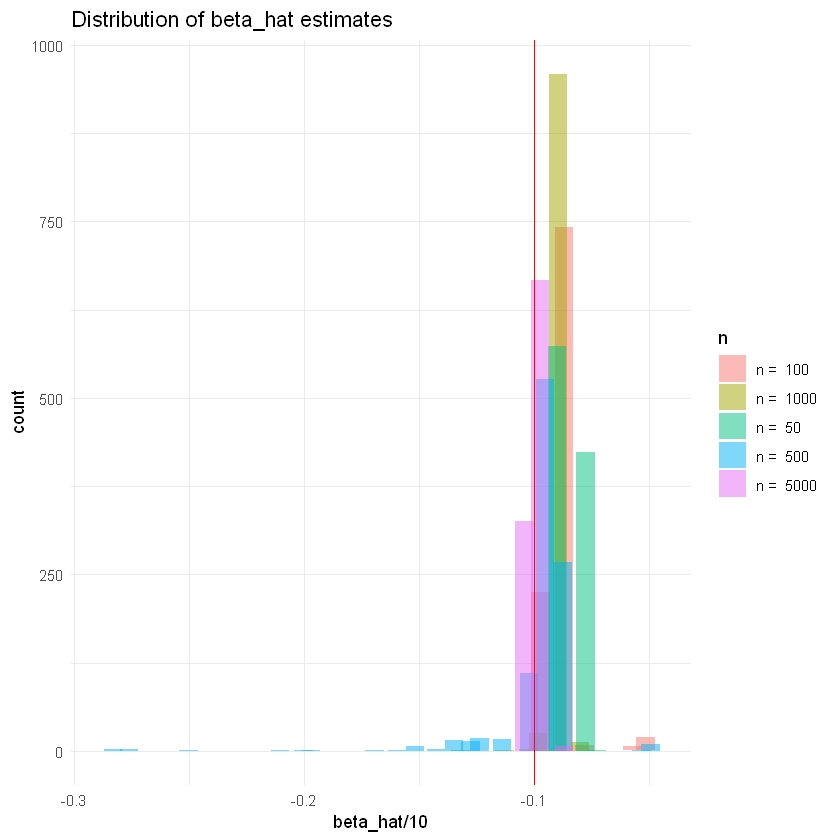

In [18]:
theme_set(theme_minimal())
ggplot(simulation_df) +
    aes(beta_hat / 10, fill = n) +
    geom_histogram(position = 'jitter', alpha = .5, bins = 30) +
    geom_vline(xintercept = true_beta, color = "red") + 
    labs(title = "Distribution of beta_hat estimates")

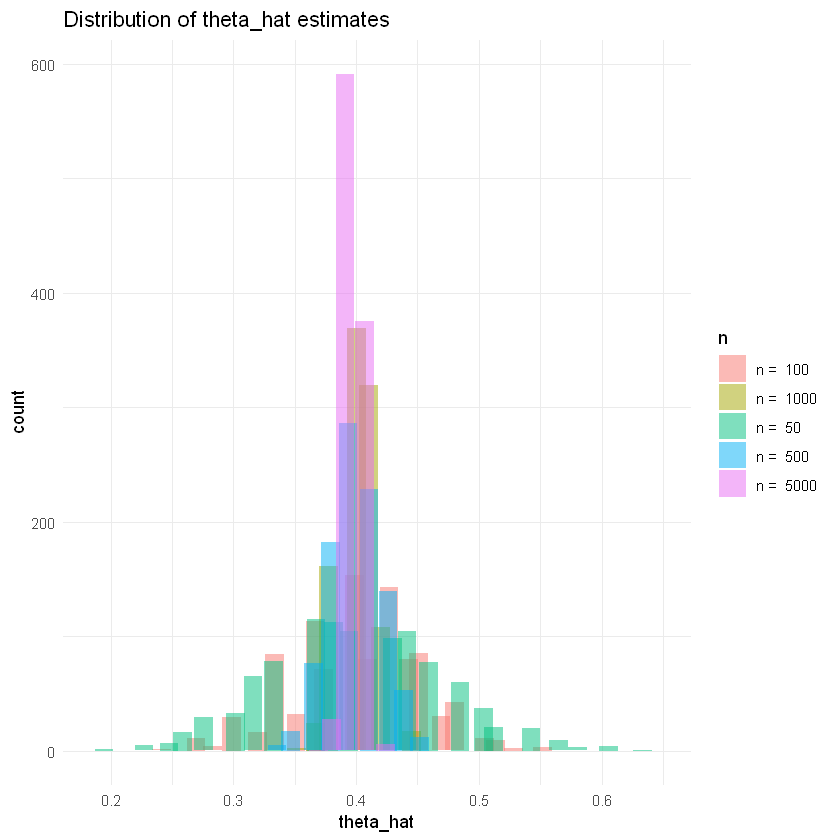

In [19]:
ggplot(simulation_df) +
    aes(theta_hat, fill = n) +
    geom_histogram(position = 'jitter', alpha = .5, bins = 30) +
    labs(title = "Distribution of theta_hat estimates")

## 6. Discuss how you would construct confidence intervals for $\beta_{hat}$ and $\theta_{hat}$

To construct confidence intervals for beta_hat and theta_hat, we can use the estimated standard errors of the estimates. In large samples, by the Central Limit Theorem, beta_hat and theta_hat are approximately normally distributed. Therefore, you can use the following formulas for the lower and upper limits of the 95% confidence interval: 

* lower_limit = estimate - 1.96 * standard_error
* upper_limit = estimate + 1.96 * standard_error

In this case, however, the standard errors of beta_hat and theta_hat are not readily available. We could estimate these by bootstrapping: resample the data with replacement, calculate beta_hat and theta_hat for each resampled dataset, and then calculate the standard deviation of these bootstrapped estimates.

The following code implements a Monte Carlo study that checks whether these bootstrapped 95% confidence intervals cover the true parameter values 95% of the time.

In [ ]:
sample_df = tibble(esti_hat = NA, value = NA, n = "", bt_bottom = 1, bt_upper = 1)
sample_sizes <- c(50, 100, 500)
num_bootstrap_samples = 50
simulation_ci = function(n_size){
    
    softmax <- function(x){
        x / sum(x)
    }
    n_txt = paste("n = ", n_size)
    print(n_txt)
    sample_datasets = function(i){
        Y_i_sample <- sample(c(0, 1, 2, 3), size = n_size, replace = TRUE, prob = softmax(true_alpha + true_beta * true_p))
        opt = optimize(Y_i_sample, true_alpha, true_beta, true_p)

        alpha_hat = opt$alpha_hat
        beta_hat = opt$beta_hat
        theta_hat = calculate_theta_hat(opt$alpha_hat, opt$beta_hat, true_p)
        bt_beta_hats = c()
        bt_theta_hats = c()
        
        for(bt in 1:num_bootstrap_samples){
            bootstrap_sample = sample(Y_i_sample, size = n_size, replace = T)
            opt_bt = optimize(bootstrap_sample, alpha_hat, beta_hat, true_p)
            bt_alpha_hat = opt_bt$alpha_hat
            bt_beta_hat = opt_bt$beta_hat
            bt_theta_hat = calculate_theta_hat(bt_alpha_hat, bt_beta_hat, true_p)
    
            bt_beta_hats = append(bt_beta_hats, bt_beta_hat)
            bt_theta_hats = append(bt_theta_hats, bt_theta_hat)
        }

        bt_beta_ci = c(quantile(bt_beta_hats, probs = c(0.025, 0.975))) / 10
        bt_theta_ci = c(quantile(bt_theta_hats, probs = c(0.025, 0.975))) / 10
        
        sample_df = sample_df |> add_row(esti_hat = "beta", value = beta_hat, n = n_txt, bt_bottom = bt_beta_ci[[1]], bt_upper = bt_beta_ci[[2]])
        # sample_df = sample_df |> add_row(esti_hat = "beta", value = beta_hat, n = n_txt, bt_ci = list(bt_beta_hats))
        sample_df = sample_df |> add_row(esti_hat = "theta", value = theta_hat, n = n_txt, bt_bottom = bt_theta_ci[[1]], bt_upper = bt_theta_ci[[2]])
        # sample_df = sample_df |> add_row(esti_hat = "theta", value = theta_hat, n = n_txt, bt_ci = list(bt_theta_hats))
        # list(bt_beta_hats, bt_theta_hats)
    }
    
    return(purrr::map_df(1:num_datasets, sample_datasets)|> drop_na(value) )
}
simulation_df = purrr::map_df(sample_sizes, simulation_ci, .progress = T)
simulation_df


[1] "n =  50"


 ■■■■■■■■■■■                       33% |  ETA:  2m


[1] "n =  100"


 ■■■■■■■■■■■■■■■■■■■■■             67% |  ETA:  1m


In [ ]:
simulation_df |> group_by(n, esti_hat) |> summarise(across(everything(), mean)) |> dplyr::select(!value)

In [ ]:
print("done")